In [114]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [115]:
# Constants given by the problem
n = 10  # number of segments
beta = 0.5  # design input parameter
L = 2 * np.pi  # assuming L is one wavelength of the sinusoidal wave

# (14) Calculate the lengths of the curved segments c and the straight segments l
c = L / n * beta
l = L / n * (1 - beta)

In [116]:
from scipy.integrate import quad
from scipy.optimize import fsolve
from scipy.misc import derivative
import numdifftools as nd
from numpy import cos, sin

In [117]:
import numpy as np
import numdifftools as nd
from scipy.integrate import quad
from scipy.optimize import fsolve

def z(x, L):
    """Sinusoidal centerline curve function."""
    return np.sin(2 * np.pi * x / L)

def dz_dx(x, L):
    """Derivative of z with respect to x."""
    z_wrapped = lambda x: z(x, L)
    derivative = nd.Derivative(z_wrapped)
    return derivative(x)

def arc_length_integral(x, L):
    """Calculate the integral of the arc length from 0 to x."""
    # Use dz_dx directly inside the integral
    result, _ = quad(lambda x_prime: np.sqrt(1 + dz_dx(x_prime, L)**2), 0, x)
    return result

def get_x(s, L):
    """Find x coordinate for a given arc length s."""
    func_to_solve = lambda x: arc_length_integral(x, L) - s
    x_initial_guess = s  # Initial guess for x
    x_solution, = fsolve(func_to_solve, x_initial_guess)
    return x_solution

# Example usage
L = 10  # Example value for L
s = 2   # Example arc length to find x for
x_solution = get_x(s, L)
z_value = z(x_solution, L)  # Calculate z using the original function

print(f"x: {x_solution}, z: {z_value}")


x: 1.7783063920861544, z: 0.8989395965094429


In [118]:
s = [] # sampled arc length, s
s_x = [] # x coordinate for arc length s
pd = [] # homogenous xyz coordinate for arc length s

for j in range(n+1):
    sj = j*L/n
    sj_x = get_x(sj, L)
    sj_z = z(sj_x, L)
    pdj = np.array([sj_x, 0, sj_z, 1]) # homogeneous coordinates

    s.append(sj)
    s_x.append(sj_x)
    pd.append(pdj) 

# print(s)
# print(s_x)
# print(pd)

In [130]:
def T_j(c, l, kj):
    # constant curvatrue bending transformation (Eq 11)
    th_j = kj * l 
    T_b_j = np.array([[cos(th_j), 0, sin(th_j), (1 - cos(th_j)) / kj],
                        [0, 1, 0, 0],
                        [-sin(th_j), 0, cos(th_j), sin(th_j) / kj],
                        [0, 0, 0, 1]
                    ])
    # rigid translation (Eq 12)
    T_r_j = np.array([[1, 0, 0, 0],
                        [0, 1, 0, 0],
                        [0, 0, 1, c],
                        [0, 0, 0, 1]
                    ])
    T_j = T_b_j @ T_r_j
    return T_j # (Eq13)


In [144]:
# Initialize array to hold the curvatures and the initial position
k_values = np.zeros(n)
pj_prev = np.array([0, 0, 0, 1])  # Assuming the robot starts at the origin with homogeneous coordinates

# Initialize the error function
def error_function(kj, j, c, l, L, pd, s_x, pj_prev):
    # Compute Tj based on the current guess of kj
    Tj = T_j(kj, c, l)
    # print("Tj shape", Tj.shape)
    # Compute the position of the end of the jth notched-rigid segment pair
    pj = Tj @ pj_prev
    # print("pj shape", pj.shape)
    # Desired position on the curve
    pdj = pd[j]
    # Normal vector calculation
    Nj = np.array([0, 0, 1])  # Assuming the normal in the x-z plane pointing upwards
    # Vector normal to the curve at sj
    Ry_90 = np.array([[0, 0, 1, 0], 
                      [0, 1, 0, 0], 
                      [-1, 0, 0, 0],
                      [0, 0, 0, 1]])
    Nj = Ry_90 @ np.array([0,0,dz_dx(s_x[j], L),1])
    # print("Nj shape", Nj.shape)
    # Error vector (component of the error which is normal to the desired curve)
    ej = Nj.T @ (pj - pdj)
    print(f"ej: {ej}, type: {type(ej)}")  # Debugging line
    return np.linalg.norm(ej), pj  # Make sure ej is scalar

# # Optimization loop to find the curvature for each segment
# for j in range(1, n + 1):
#     # Use fsolve to find the curvature that minimizes the error
#     k_initial_guess = 1/L
#     # args passed to error_function does not include kj since it is the unknown we are solving for
#     ej, pj = error_function(k_initial_guess,j, c, l, L, pd, s_x, pj_prev)
#     # Update the previous position for the next iteration
#     pj_prev = pj
def modified_error_function(kj, j, c, l, L, pd, s_x, pj_prev):
    # Your existing logic here
    ej, _ = error_function(kj, j, c, l, L, pd, s_x, pj_prev)  # Assuming ej is the error
    return ej  # Return only the error component for fsolve

# Optimization loop
for j in range(1, n + 1):
    k_initial_guess = 1/L
    func = lambda kj: modified_error_function(kj, j, c, l, L, pd, s_x, pj_prev)
    kj_solution, = fsolve(func, k_initial_guess)
    # Re-evaluate to get updated pj using the solved curvature
    _, pj = error_function(kj_solution, j, c, l, L, pd, s_x, pj_prev)
    # Store the solution
    k_values[j-1] = kj_solution
    # Update pj_prev for the next iteration
    pj_prev = pj
    print(f"Segment {j}, Curvature: {kj_solution}")

# # Optimization loop to find the curvature for each segment
# for j in range(1, n + 1):
#     # Use fsolve to find the curvature that minimizes the error
#     k_initial_guess = 1/L
#     # args passed to error_function does not include kj since it is the unknown we are solving for
#     k_solution = fsolve(error_function, k_initial_guess, args=(j, c, l, L, pd, s_x, pj_prev))
#     k_values[j - 1] = k_solution[0]
#     # Update the previous position for the next iteration
#     pj_prev = T_j(k_values[j - 1], c, l) @ pj_prev


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (4, 4) + inhomogeneous part.

In [ ]:
# Plotting the original and the approximated curve
s_fine = np.linspace(0, L, 1000)
pd_fine = pd(s_fine, L)

plt.figure(figsize=(12, 6))
plt.plot(s_fine, pd_fine, label='Original Curve pd(s)')

# Plot the approximated curve using straight and curved segments
for j in range(n):
    sj = s_values[j]
    # plt.plot([sj, sj + l], [pd(sj, L), pd(sj + l, L)], 'ro-')  # Straight segment
    # For curved segment, we'll just plot a point for simplicity, as we don't have
    # the actual function for the curved segment shape
    # plt.plot(sj + l + c/2, pd(sj + l + c/2, L), 'bo')  # Curved segment midpoint
    plt.plot(get_xcoord(sj + l, L), pd(get_xcoord(sj + l, L), L), 'bo')  # Curved segment midpoint


plt.xlabel('s')
plt.ylabel('pd(s)')
plt.title('Original vs Approximated Curve')
plt.legend()
plt.grid(True)
plt.axis('square') 
plt.show()

# Output the calculated lengths and curvatures
c, l, k_values

In [ ]:
n = 1 # segment number
beta = 0.5 # design input parameter β -> determines the curved and straight segment
L = 20 # total length


# given segment number (n) and centerline continuous curve pd(s)
# find curved segment c, straight segment l, and curvature k

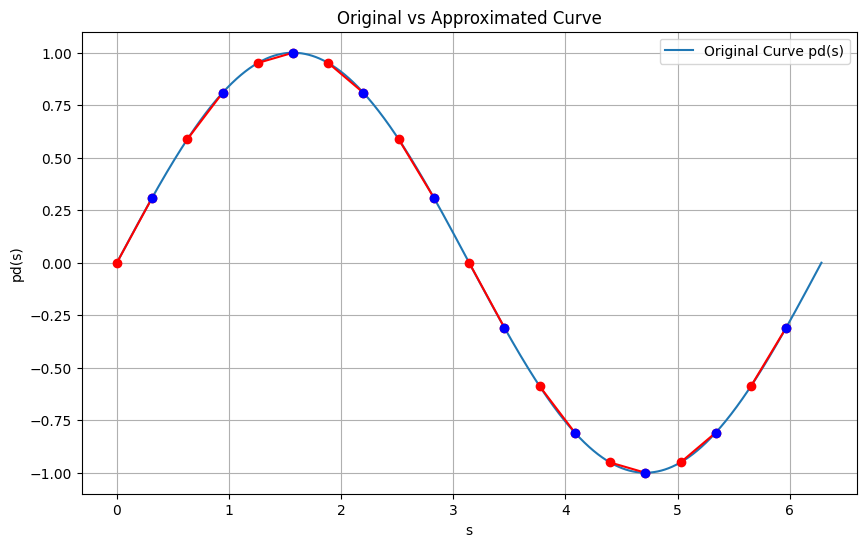

(0.3141592653589793,
 0.3141592653589793,
 array([0.15915494, 0.15915494, 0.15915494, 0.15915494, 0.15915494,
        0.15915494, 0.15915494, 0.15915494, 0.15915494, 0.15915494]))

In [154]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Constants given by the problem
n = 10  # number of segments
beta = 0.5  # design input parameter
L = 2 * np.pi  # assuming L is one wavelength of the sinusoidal wave

# Calculate the lengths of the curved segments c and the straight segments l
c = L / n * beta
l = L / n * (1 - beta)

# Define the sinusoidal centerline curve pd(s)
def pd(s, L):
    return np.sin(2 * np.pi * s / L)

# Sample the desired curve at n + 1 evenly spaced points
s_values = np.linspace(0, L, n + 1)

# Define the error function for fsolve to find the curvature that minimizes the error
def error_function(kj, sj, c, l, pd, L):
    # Position of the end of the jth notched-rigid segment pair
    pj = np.array([sj + l + c/2, pd(sj + l + c/2, L)])
    # Desired position on the curve
    pdj = np.array([sj, pd(sj, L)])
    # Vector normal to the curve at sj
    Nj = np.array([-np.cos(2 * np.pi * sj / L), np.sin(2 * np.pi * sj / L)])
    # Error vector
    ej = pj - pdj
    # Return the component of the error which is normal to the desired curve
    return np.dot(ej, Nj)

# Initialize array to hold the curvatures
k_values = np.zeros(n)

# Find the curvature for each segment
for j in range(1, n + 1):
    sj = s_values[j - 1]
    # Use fsolve to find the curvature that minimizes the error
    k_initial_guess = 1/L
    k_solution = fsolve(error_function, k_initial_guess, args=(sj, c, l, pd, L))
    k_values[j - 1] = k_solution[0]

# Plotting the original and the approximated curve
s_fine = np.linspace(0, L, 1000)
pd_fine = pd(s_fine, L)

plt.figure(figsize=(10, 6))
plt.plot(s_fine, pd_fine, label='Original Curve pd(s)')

# Plot the approximated curve using straight and curved segments
for j in range(n):
    sj = s_values[j]
    plt.plot([sj, sj + l], [pd(sj, L), pd(sj + l, L)], 'ro-')  # Straight segment
    # For curved segment, we'll just plot a point for simplicity, as we don't have
    # the actual function for the curved segment shape
    plt.plot(sj + l, pd(sj + l, L), 'bo')  # Curved segment midpoint

plt.xlabel('s')
plt.ylabel('pd(s)')
plt.title('Original vs Approximated Curve')
plt.legend()
plt.grid(True)
plt.show()

# Output the calculated lengths and curvatures
c, l, k_values
